## Author: Akash

### Visualising changes in minority population distributions from 2010 to 2018

Data Source: ACS 5 Yr Census 2010 (US Census Bureau), ACS 5 Yr Census 2018 (US Census Bureau), Redlining Geofiles

In [ ]:
#Loading needed libraries
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import fiona
from shapely.geometry import shape, mapping
import rtree
import fiona.crs
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import os
import splot
import pysal
from libpysal import weights
import esda
from esda.moran import Moran, Moran_Local,Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation, moran_scatterplot

In [ ]:
#Reading the redlined data
geo_files = [
"/home/jovyan/work/COVIDRedlining/data/dallas/dallas_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/detroit/detroit_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/new york/ny_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/minneapolis/minneapolis_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/california/cali_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/boston/boston_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/tampa/tampa_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/newark/newark_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/chicago/chicago_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/atlanta/atlanta_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/houston/houston_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/nashville/nashville_redlined_numerical_values.geojson",
"/home/jovyan/work/COVIDRedlining/data/stlouis/stlouis_redlined_numerical_values.geojson"
]

dfs = [gpd.read_file(x) for x in geo_files]

In [ ]:
# Loading rental data (spatial)
rent_data = gpd.read_file('/datasets/rent_prioritisation/housing_index_state_adj.geojson')
rent_data.head()

In [ ]:
#Combining all geo-files together and rounding the reweighted redline index to 2 decimal values
geo_intersect = pd.DataFrame(pd.concat(dfs))
geo_intersect['reweighted_redline_index'] = geo_intersect['reweighted_redline_index'].round(2)
geo_intersect.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,reweighted_redline_index,ordinal_value,geometry
0,48,113,980100,4.811398e+10,9801,Census Tract 9801,G5020,S,5493433,0,+32.8455619,-096.8494250,3.10,4,"POLYGON ((-96.86907 32.84576, -96.86893 32.846..."
1,48,113,000605,4.811300e+10,6.05,Census Tract 6.05,G5020,S,537957,0,+32.8104817,-096.8071671,2.09,3,"POLYGON ((-96.81350 32.81280, -96.81263 32.813..."
2,48,113,007101,4.811301e+10,71.01,Census Tract 71.01,G5020,S,1180246,0,+32.8443119,-096.8175334,1.00,1,"POLYGON ((-96.82198 32.83702, -96.82187 32.837..."
3,48,113,004201,4.811300e+10,42.01,Census Tract 42.01,G5020,S,2569176,9714,+32.7584519,-096.8299088,2.16,3,"POLYGON ((-96.83757 32.75015, -96.83756 32.750..."
4,48,113,005901,4.811301e+10,59.01,Census Tract 59.01,G5020,S,2898961,0,+32.6930920,-096.8082157,3.00,3,"POLYGON ((-96.81470 32.69375, -96.81467 32.695..."


In [ ]:
#Merging geofiles with the rental prioritisation index data
rent_data['GEOID'] = rent_data['GEOID'].astype(float)
rent_redline_data = geo_intersect.merge(rent_data,on='GEOID',how='left',suffixes=('_redline','_rent'))
rent_redline_data.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,...,z_score_perc_poverty_12mnth_quantile,z_score_perc_no_hinsure_quantile,z_score_perc_person_of_color_quantile,z_score_perc_public_assistance_quantile,z_score_perc_foreign_born_quantile,z_score_perc_30hamfi_quantile,z_score_perc_low_income_jobs_lost_quantile,num_ELI,grayed_out,geometry_rent
0,48,113,980100,4.811398e+10,9801,Census Tract 9801,G5020,S,5493433,0,...,0.01,0.01,0.99,0.17,0.97,0.05,0.91,0.0,1.0,"MULTIPOLYGON (((-96.86607 32.84849, -96.86446 ..."
1,48,113,000605,4.811300e+10,6.05,Census Tract 6.05,G5020,S,537957,0,...,0.19,0.07,0.19,0.26,0.67,0.48,0.88,170.0,0.0,"MULTIPOLYGON (((-96.81350 32.81280, -96.80998 ..."
2,48,113,007101,4.811301e+10,71.01,Census Tract 71.01,G5020,S,1180246,0,...,0.39,0.02,0.07,0.41,0.55,0.26,0.86,60.0,0.0,"MULTIPOLYGON (((-96.82185 32.83737, -96.82160 ..."
3,48,113,004201,4.811300e+10,42.01,Census Tract 42.01,G5020,S,2569176,9714,...,0.62,0.53,0.62,0.53,0.63,0.51,0.67,160.0,0.0,"MULTIPOLYGON (((-96.83745 32.75238, -96.83746 ..."
4,48,113,005901,4.811301e+10,59.01,Census Tract 59.01,G5020,S,2898961,0,...,0.79,0.59,0.92,0.91,0.50,0.88,0.48,265.0,0.0,"MULTIPOLYGON (((-96.81463 32.70297, -96.81458 ..."


In [ ]:
#Subsetting the data for running correlations
corr_data = rent_redline_data[['GEOID','state_name','county_name','total_index_quantile','perc_person_of_color','ordinal_value']]
corr_data.head()

,GEOID,state_name,county_name,total_index_quantile,perc_person_of_color,ordinal_value
0,4.811398e+10,Texas,Dallas County,0.54,1.000000,4
1,4.811300e+10,Texas,Dallas County,0.37,0.269623,3
2,4.811301e+10,Texas,Dallas County,0.21,0.158301,1
3,4.811300e+10,Texas,Dallas County,0.67,0.687595,3
4,4.811301e+10,Texas,Dallas County,0.81,0.965158,3


In [ ]:
#Subsetting the data to only include the 14 cities under study
states = ['New York','California','Illinois','Michigan','Missouri','Texas','Georgia','Tennessee','Massachusetts','New Jersey','Minnesota','Florida']
counties = ['Kings County','Richmond County', 'Bronx County', ' Queens County', 'New York County',
'Los Angeles County','San Francisco County','Cook County','Wayne County','St. Louis County','Harris County',
'Dallas County','Fulton County','Davidson County','Suffolk County','Essex County','Hennepin County','Hillsborough County']
corr_data = corr_data[corr_data['state_name'].isin(states)]
corr_data = corr_data[corr_data['county_name'].isin(counties)]
corr_data.shape

(5574, 6)

In [ ]:
#Assigning a new column having the city name against each census tract
def city_name(row):
    if row['county_name'] == 'Kings County':
      val = 'New York'
    elif row['county_name'] == 'Richmond County':
      val = 'New York'
    elif row['county_name'] == 'Bronx County':
      val = 'New York'
    elif row['county_name'] == ' Queens County':
      val = 'New York'
    elif row['county_name'] == 'New York County':
      val = 'New York'
    elif row['county_name'] == 'Los Angeles County':
      val = 'Los Angeles'
    elif row['county_name'] == 'San Francisco County':
      val = 'San Francisco'
    elif row['county_name'] == 'Cook County':
      val = 'Chicago'
    elif row['county_name'] == 'Wayne County':
      val = 'Detroit'
    elif row['county_name'] == 'St. Louis County':
      val = 'St. Louis'
    elif row['county_name'] == 'Harris County':
      val = 'Houston'
    elif row['county_name'] == 'Dallas County':
      val = 'Dallas' 
    elif row['county_name'] == 'Fulton County':
      val = 'Atlanta'
    elif row['county_name'] == 'Davidson County':
      val = 'Nashville' 
    elif row['county_name'] == 'Suffolk County' and row['state_name'] == 'Massachusetts':
      val = 'Boston'
    elif row['county_name'] == 'Essex County':
      val = 'Newark'
    elif row['county_name'] == 'Hennepin County':
      val = 'Minneapolis' 
    elif row['county_name'] == 'Hillsborough County':
      val = 'Tampa' 
    else:
      val = 0

    return val

corr_data['city_name'] = corr_data.apply(city_name, axis=1)

In [ ]:
#Joining with correlation data
rent_data['GEOID'] = rent_data['GEOID'].astype(float)
spatial_corr_data = rent_data[['GEOID','geometry']].merge(corr_data,on='GEOID',how='right')
spatial_corr_data.head()

,GEOID,geometry,state_name,county_name,total_index_quantile,perc_person_of_color,ordinal_value,city_name
0,6.037550e+09,"MULTIPOLYGON (((-118.11354 33.95430, -118.1116...",California,Los Angeles County,0.49,0.823853,3,Los Angeles
1,6.037551e+09,"MULTIPOLYGON (((-118.12323 33.93708, -118.1218...",California,Los Angeles County,0.47,0.802353,2,Los Angeles
2,6.037603e+09,"MULTIPOLYGON (((-118.29978 33.88015, -118.2997...",California,Los Angeles County,0.71,0.900321,4,Los Angeles
3,6.037603e+09,"MULTIPOLYGON (((-118.31348 33.88706, -118.3134...",California,Los Angeles County,0.68,0.906136,4,Los Angeles
4,6.037603e+09,"MULTIPOLYGON (((-118.31349 33.88195, -118.3091...",California,Los Angeles County,0.73,0.887410,4,Los Angeles


In [ ]:
#Renaming columns
spatial_corr_data = spatial_corr_data.rename(columns={'total_index_quantile':'rental_assistance_index','perc_person_of_color':'percentage_minority','ordinal_value':'redlining_index'})

In [ ]:
#Overall Percentage of Minority Across Cities - Mean of percentage minority across all census tracts within the city
spatial_corr_data.groupby(['city_name'])['percentage_minority'].mean().reset_index()

,city_name,percentage_minority
0,Atlanta,0.634487
1,Boston,0.512522
2,Chicago,0.653449
3,Dallas,0.624807
4,Detroit,0.692924
5,Houston,0.755306
6,Los Angeles,0.740358
7,Minneapolis,0.407627
8,Nashville,0.434719
9,New York,0.646009


In [ ]:
#Creating a minority distribution dataframe containing total tracts, minority and non-minority population distributions
minority_df = pd.DataFrame(columns=['city_name','total_tracts','minority_tracts_perc','non_minority_tract_perc','0_25_perc_minority','25_50_perc_minority','50_75_perc_minority','75_100_perc_minority']) ##Defining the table structure
for i in spatial_corr_data['city_name'].unique(): #for each city
    num_tracts = len(spatial_corr_data[(spatial_corr_data['city_name']==i)]) #Number of tracts within each city
    minority_tracts = round((len(spatial_corr_data[(spatial_corr_data['city_name']==i)&(spatial_corr_data['percentage_minority']>=0.9)])/len(spatial_corr_data[(spatial_corr_data['city_name']==i)]))*100,2) ##Percentage of fully minority tracts within city where fully minority tracts are defined as tracts have minority population greater than or equal to 90%
    non_minority_tracts = round(len(spatial_corr_data[(spatial_corr_data['city_name']==i)&(spatial_corr_data['percentage_minority']<=0.1)])/len(spatial_corr_data[(spatial_corr_data['city_name']==i)])*100,2) ##Percentage of fully non-minority tracts within city where fully non-minority tracts are defined as tracts have minority population lesser than or equal to 10%
    percent_minority_0_25 = round(len(spatial_corr_data[(spatial_corr_data['city_name']==i) & (spatial_corr_data['percentage_minority'].between(0, 0.25))])/len(spatial_corr_data[(spatial_corr_data['city_name']==i)])*100,2) ##Percentage of minority census tracts with minority populations lying between 0-25% 
    percent_minority_25_50 = round(len(spatial_corr_data[(spatial_corr_data['city_name']==i) & (spatial_corr_data['percentage_minority'].between(0.25, 0.5))])/len(spatial_corr_data[(spatial_corr_data['city_name']==i)])*100,2) ##Percentage of minority census tracts with minority populations lying between 25-50% 
    percent_minority_50_75 = round(len(spatial_corr_data[(spatial_corr_data['city_name']==i) & (spatial_corr_data['percentage_minority'].between(0.5, 0.75))])/len(spatial_corr_data[(spatial_corr_data['city_name']==i)])*100,2) ##Percentage of minority census tracts with minority populations lying between 50-75% 
    percent_minority_75_100 = round(len(spatial_corr_data[(spatial_corr_data['city_name']==i) & (spatial_corr_data['percentage_minority'].between(0.75, 1))])/len(spatial_corr_data[(spatial_corr_data['city_name']==i)])*100,2) ##Percentage of minority census tracts with minority populations lying between 75-100% 
    #mean_minority_perc = round(len(spatial_corr_data[(spatial_corr_data['city_name']==i) & (spatial_corr_data['percentage_minority'].between(0.75, 1))])/len(spatial_corr_data[(spatial_corr_data['city_name']==i)])*100,2)
    city_list = [i,num_tracts,minority_tracts,non_minority_tracts,percent_minority_0_25,percent_minority_25_50,percent_minority_50_75,percent_minority_75_100]
    df_length = len(minority_df)
    minority_df.loc[df_length] = city_list

In [ ]:
#Inspecting the created dataset
minority_df

,city_name,total_tracts,minority_tracts_perc,non_minority_tract_perc,0_25_perc_minority,25_50_perc_minority,50_75_perc_minority,75_100_perc_minority
0,Los Angeles,1482,45.34,0.47,6.21,17.68,15.25,60.93
1,San Francisco,169,10.06,0.00,5.92,36.69,33.14,24.26
2,Tampa,60,13.33,0.00,16.67,26.67,25.00,31.67
3,Atlanta,100,34.00,3.00,18.00,19.00,15.00,48.00
4,Chicago,1013,36.62,1.38,14.71,21.42,16.09,47.78
5,Boston,178,15.73,8.43,24.16,28.09,20.79,26.97
6,Detroit,440,46.59,8.64,20.23,8.64,10.00,61.14
7,Minneapolis,122,0.82,5.74,34.43,33.61,16.39,15.57
8,St. Louis,65,21.54,15.38,43.08,16.92,7.69,32.31
9,Newark,204,51.47,0.49,10.78,16.67,12.25,59.80


/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/venv/lib/python3.7/site-packages/seaborn/axisgrid.py:392: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, axes = plt.subplots(nrow, ncol, **kwargs)


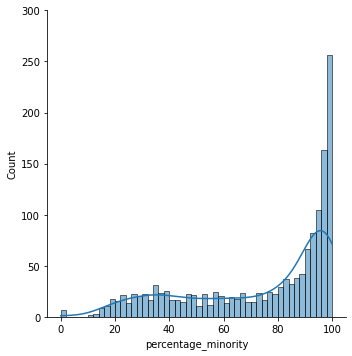

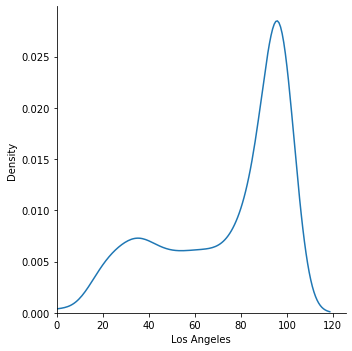

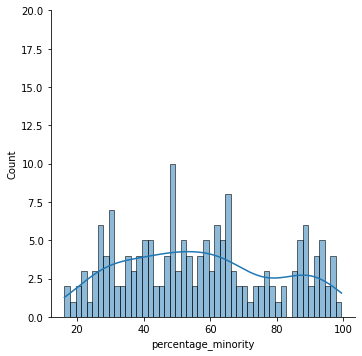

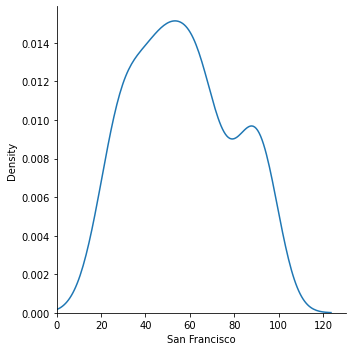

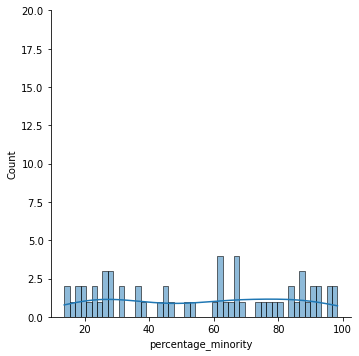

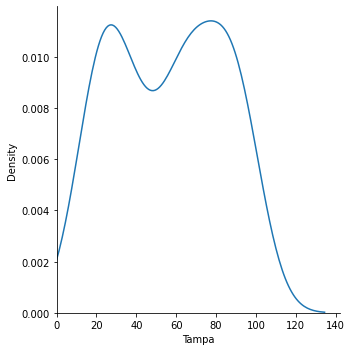

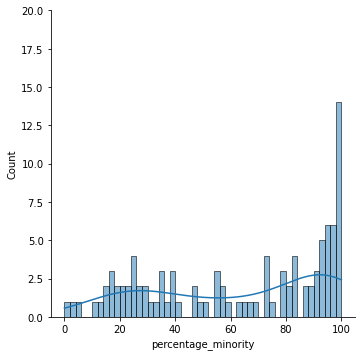

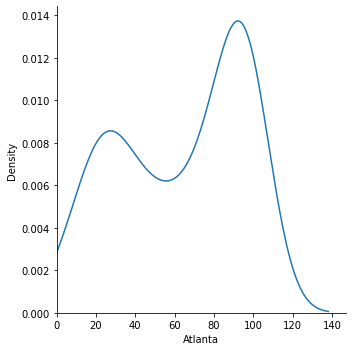

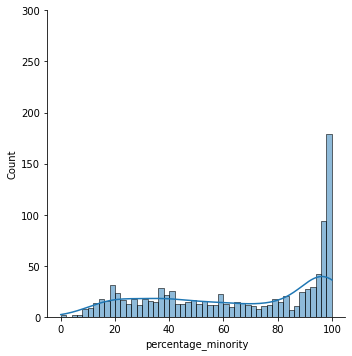

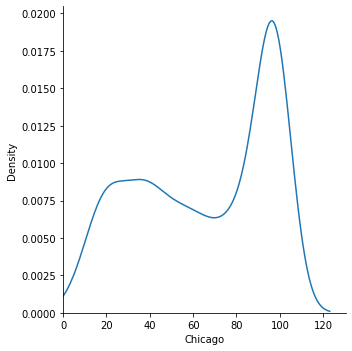

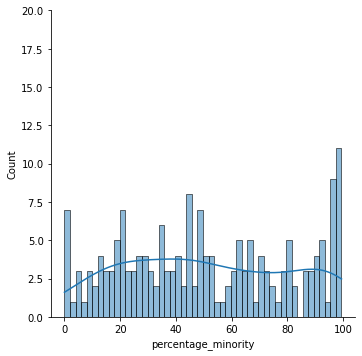

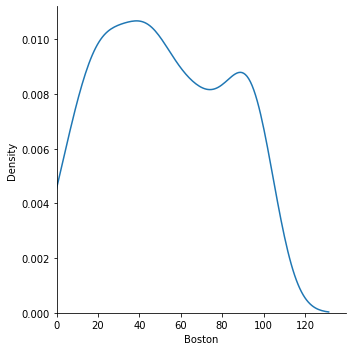

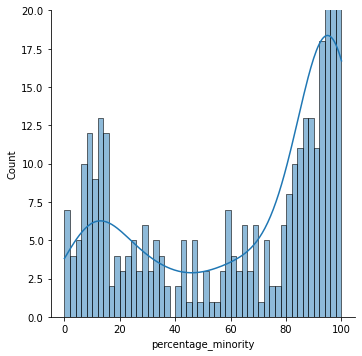

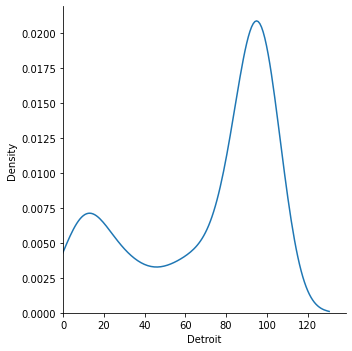

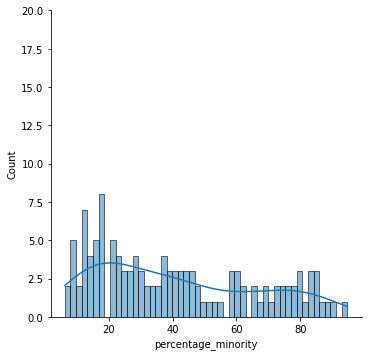

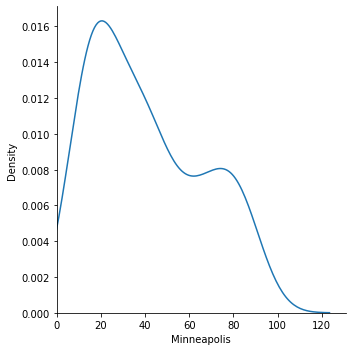

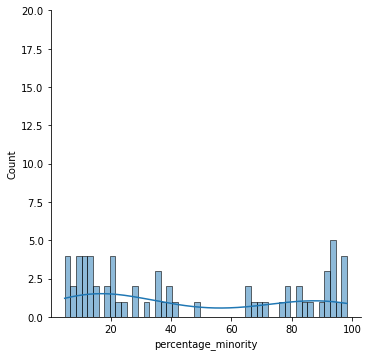

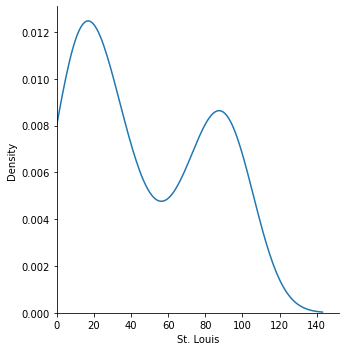

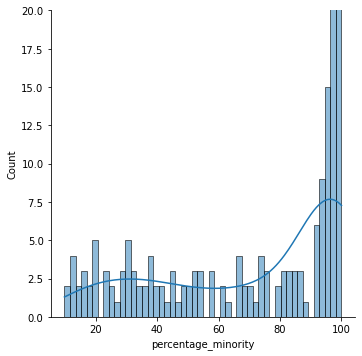

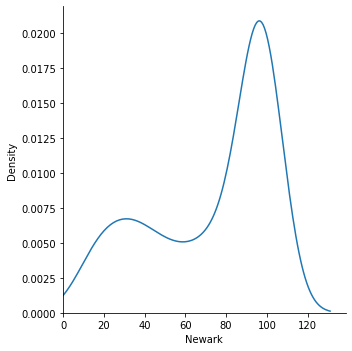

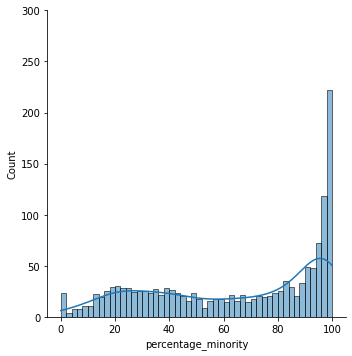

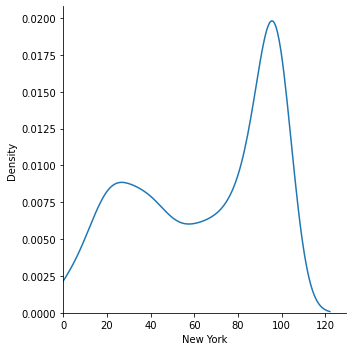

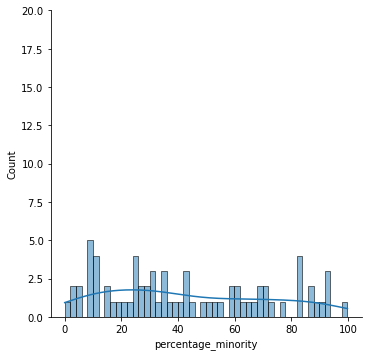

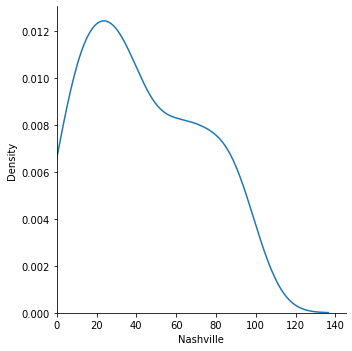

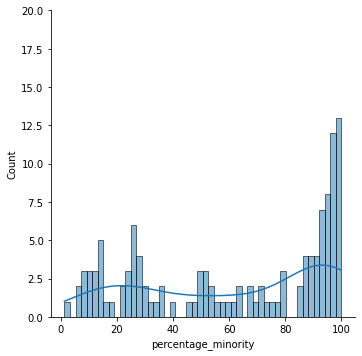

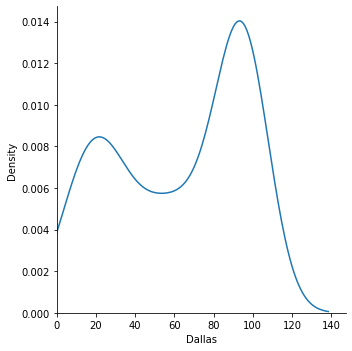

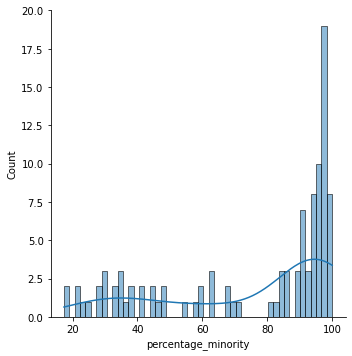

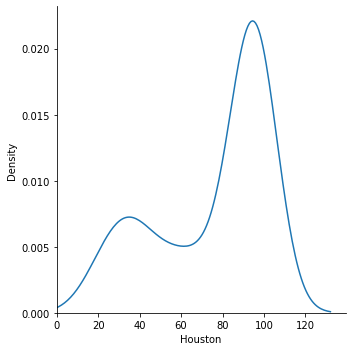

In [ ]:
#Histograms for minority population distribution

minority_hist_df = spatial_corr_data[['GEOID','city_name','percentage_minority']]
minority_hist_df['percentage_minority'] = minority_hist_df['percentage_minority']*100

#Looping the graphs together
for i in minority_hist_df['city_name'].unique():
    ax = sns.displot(minority_hist_df[minority_hist_df['city_name']==i]['percentage_minority'], bins = 50, kde= True) #With bins = 50
    #Controlling the axis sizes based on number of total tracts
    if minority_hist_df[minority_hist_df['city_name']==i]['percentage_minority'].count() < 450: #if census tracts count is less than 450, we will adjust the axis scales/limits
        vmin = 0
        vmax = 20
    else:
        vmin = 0
        vmax = 300
        
    plt.ylim(vmin,vmax)
    #mean=minority_hist_df['perc_person_of_color'].mean()
    #plt.axvline(mean,color='b', linestyle='--')
    #plt.legend({'Mean':mean})
    
    #Plotting the kernel density estimator along with bin-plots
    ax = sns.displot(minority_hist_df[minority_hist_df['city_name']==i]['percentage_minority'], kind='kde').set(xlim=(0))
    ax.set_axis_labels(i)

In [ ]:
#Distribution of minority populations by number of census tracts
minority_hist_df['rental_assistance_index'] = spatial_corr_data[['rental_assistance_index']]*100
minority_hist_df['redlining_index'] = spatial_corr_data[['redlining_index']]
minority_hist_df['city_name'] = spatial_corr_data[['city_name']]

#Creating datadrame with statistical ranges, mean, median and quartiles of minority population distribution across all cities
describe_df = pd.DataFrame(columns=['city_name','tract_count','mean','std','min','max','range','median','25%','50%','75%'])
for i in minority_hist_df['city_name'].unique():
    tract_count = len(minority_hist_df[(minority_hist_df['city_name']==i)])
    mean = minority_hist_df[(minority_hist_df['city_name']==i)]['percentage_minority'].mean()
    std = minority_hist_df[(minority_hist_df['city_name']==i)]['percentage_minority'].std()
    mini = minority_hist_df[(minority_hist_df['city_name']==i)]['percentage_minority'].min()
    maxi = minority_hist_df[(minority_hist_df['city_name']==i)]['percentage_minority'].max()
    range_city = maxi - mini
    median = minority_hist_df[(minority_hist_df['city_name']==i)]['percentage_minority'].median()
    q25 = minority_hist_df[(minority_hist_df['city_name']==i)]['percentage_minority'].quantile(0.25)
    q50 = minority_hist_df[(minority_hist_df['city_name']==i)]['percentage_minority'].quantile(0.5)
    q75 = minority_hist_df[(minority_hist_df['city_name']==i)]['percentage_minority'].quantile(0.75)
    describe_list = [i,tract_count,mean,std,mini,maxi,range_city,median,q25,q50,q75]
    df_length = len(describe_df)
    describe_df.loc[df_length] = describe_list

/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/shared-libs/python3.7/py-core/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [ ]:
#Visualising by descending number of tracts
describe_df.sort_values(by='tract_count',ascending=False)

,city_name,tract_count,mean,std,min,max,range,median,25%,50%,75%
0,Los Angeles,1482,74.035754,26.816541,0.000000,100.000000,100.000000,86.512432,52.343882,86.512432,96.702569
10,New York,1445,64.600910,31.482805,0.000000,100.000000,100.000000,72.563826,35.011062,72.563826,95.520282
4,Chicago,1013,65.344929,30.658480,0.000000,100.000000,100.000000,70.744289,37.009577,70.744289,96.636245
6,Detroit,440,69.292352,34.459105,0.000000,100.000000,100.000000,87.508710,35.418490,87.508710,97.310339
9,Newark,204,73.220939,29.969793,9.798396,100.000000,90.201604,91.959646,46.923653,91.959646,98.203846
5,Boston,178,51.252179,30.152354,0.000000,99.404489,99.404489,48.839532,25.410702,48.839532,78.507012
1,San Francisco,169,56.773025,22.468952,16.224553,99.402093,83.177540,54.547325,39.051919,54.547325,74.351320
7,Minneapolis,122,40.762679,25.050254,6.257631,94.770992,88.513361,36.343211,18.220024,36.343211,60.613594
12,Dallas,122,62.480677,33.585600,1.314060,100.000000,98.685940,71.208633,27.103239,71.208633,94.671408
13,Houston,103,75.530586,26.995187,17.369920,100.000000,82.630080,91.200000,51.145620,91.200000,96.744978


### Intercensal Changes

In [ ]:
#Reading 2010 and 2018 census data
acs_2010 = pd.read_csv('/work/COVIDRedlining/data/ACS/acs_census_tract_2010_5yr')
acs_2018 = pd.read_csv('/work/COVIDRedlining/data/ACS/acs_census_tract_2018_5yr.csv')

In [ ]:
#Creating minority proportion columns for both datasets
acs_2010 = acs_2010.rename(columns={'geo_id':'GEOID'})
acs_2018 = acs_2018.rename(columns={'geo_id':'GEOID'})
acs_2010['GEOID'] = acs_2010['GEOID'].astype(float)
acs_2018['GEOID'] = acs_2018['GEOID'].astype(float)

#Creating minority population columns as sum of black, asian,hispanic, american-indian within each census tract and dividing with the total population
acs_2010['acs10_minority_prop'] = round(((acs_2010['black_pop'] + acs_2010['asian_pop'] + acs_2010['hispanic_pop'] + acs_2010['amerindian_pop'])/acs_2010['total_pop'])*100,2)
acs_2018['acs18_minority_prop'] = round(((acs_2018['black_pop'] + acs_2018['asian_pop'] + acs_2018['hispanic_pop'] + acs_2018['amerindian_pop'])/acs_2018['total_pop'])*100,2)

In [ ]:
#Merging with minority population (having rental and redline index) dataframe
minority_hist_df = minority_hist_df.merge(acs_2010[['GEOID','acs10_minority_prop']],on='GEOID',how='left')
minority_hist_df = minority_hist_df.merge(acs_2018[['GEOID','acs18_minority_prop']],on='GEOID',how='left')
minority_hist_df.head()

,GEOID,city_name,percentage_minority,rental_assistance_index,redlining_index,acs10_minority_prop,acs18_minority_prop
0,6.037550e+09,Los Angeles,82.385254,49.0,3,78.61,80.99
1,6.037551e+09,Los Angeles,80.235262,47.0,2,67.38,77.76
2,6.037603e+09,Los Angeles,90.032068,71.0,4,94.48,87.39
3,6.037603e+09,Los Angeles,90.613625,68.0,4,82.35,83.96
4,6.037603e+09,Los Angeles,88.741044,73.0,4,84.56,87.28


/opt/venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/venv/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for

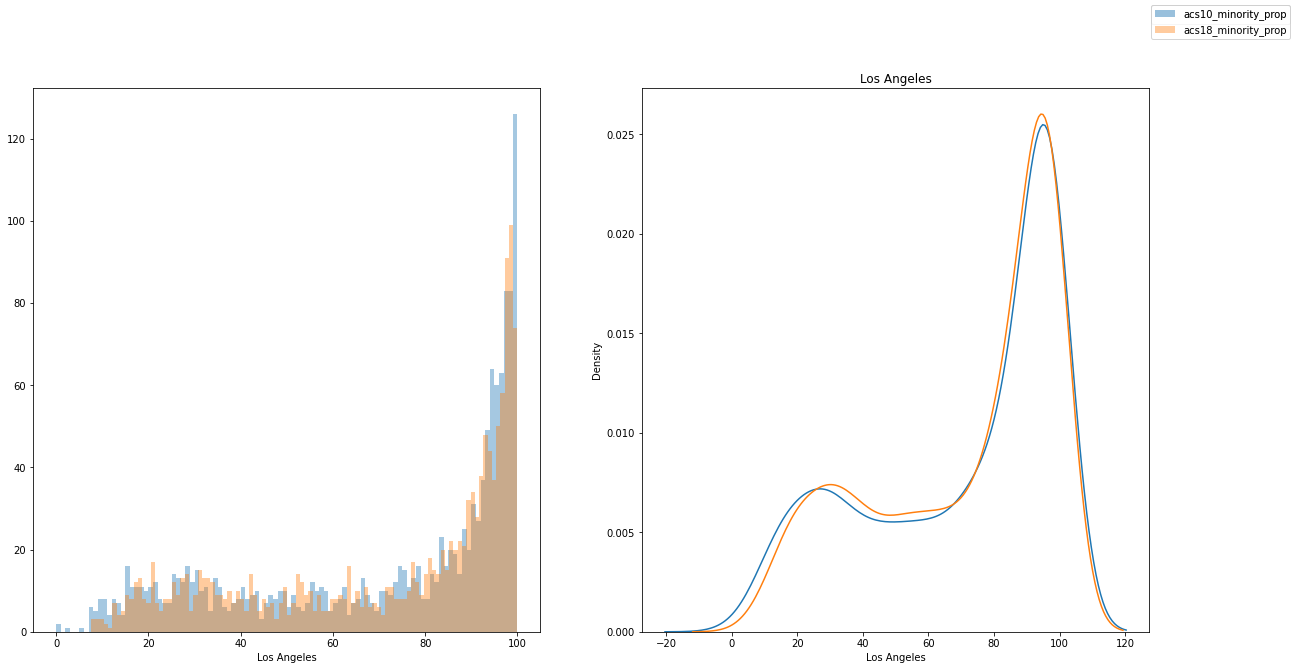

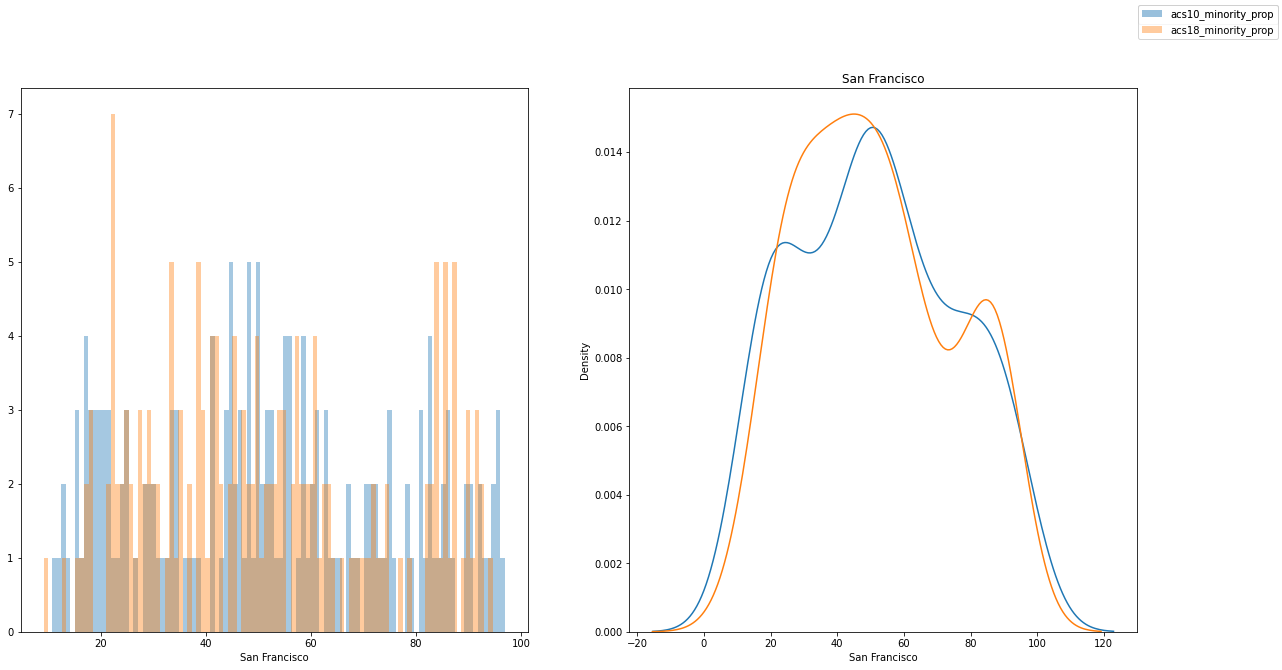

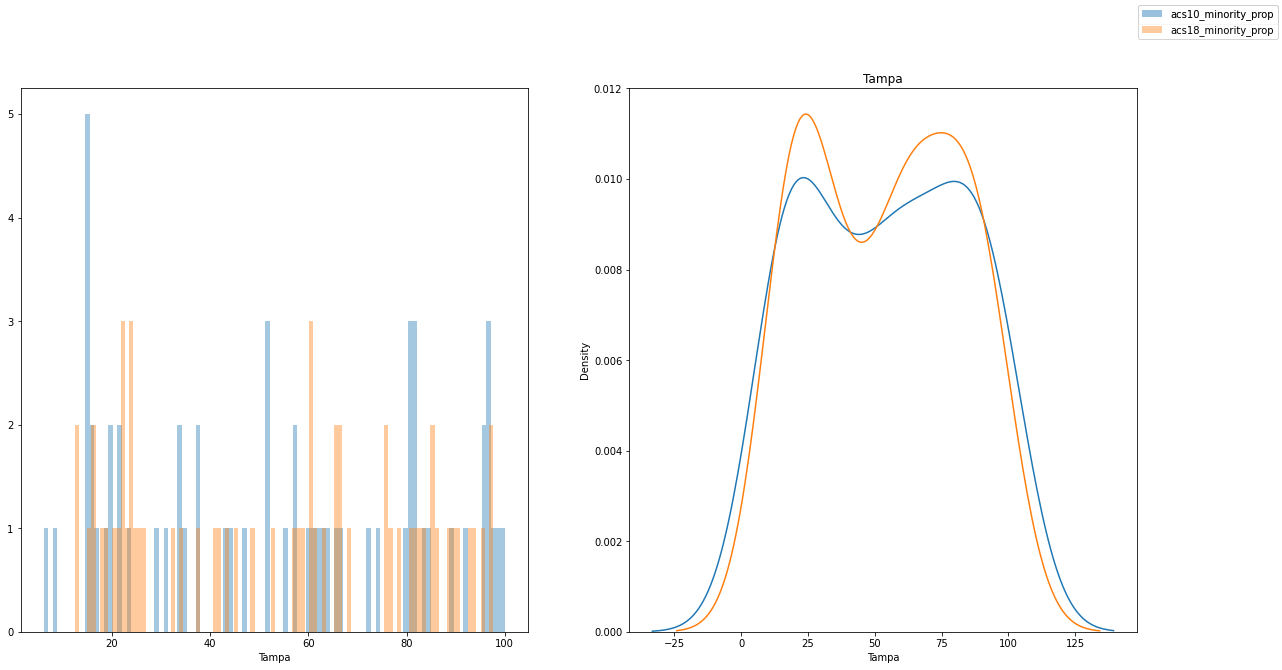

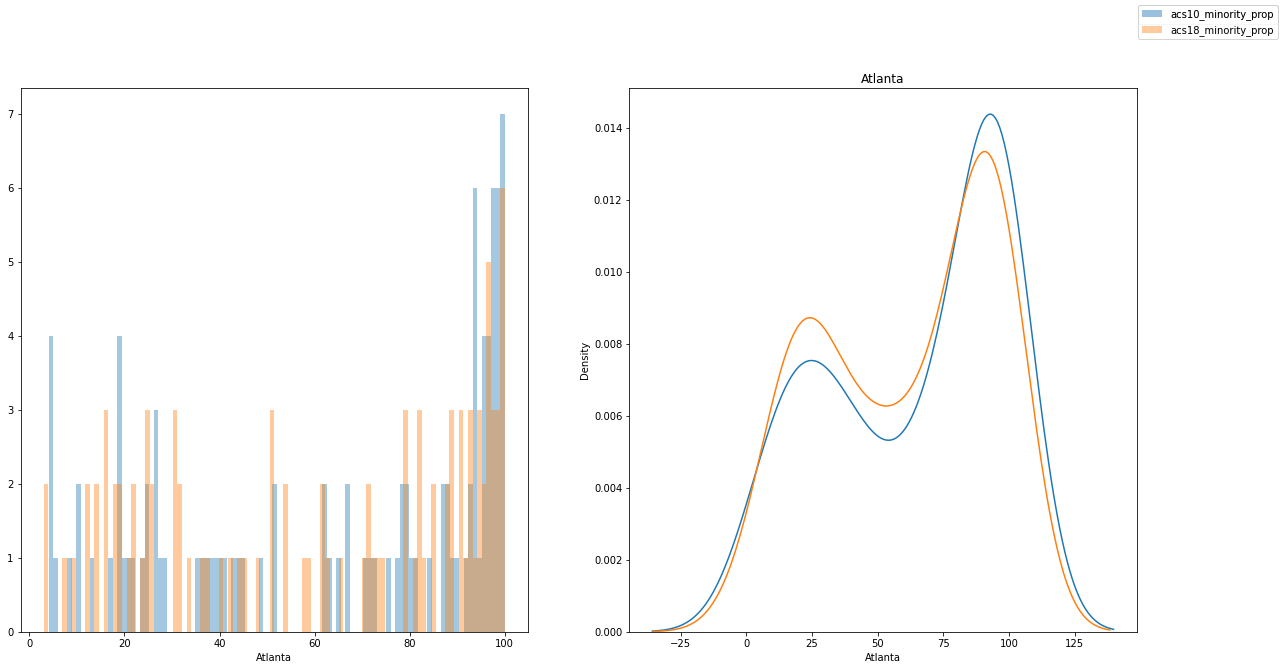

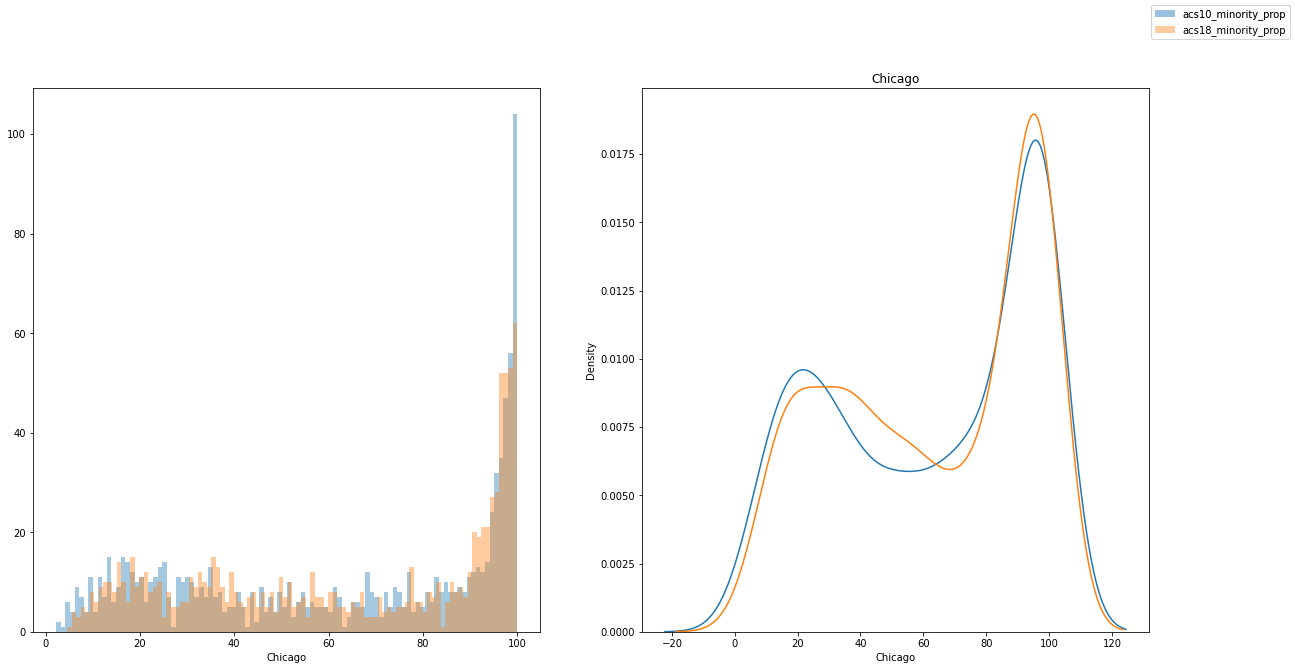

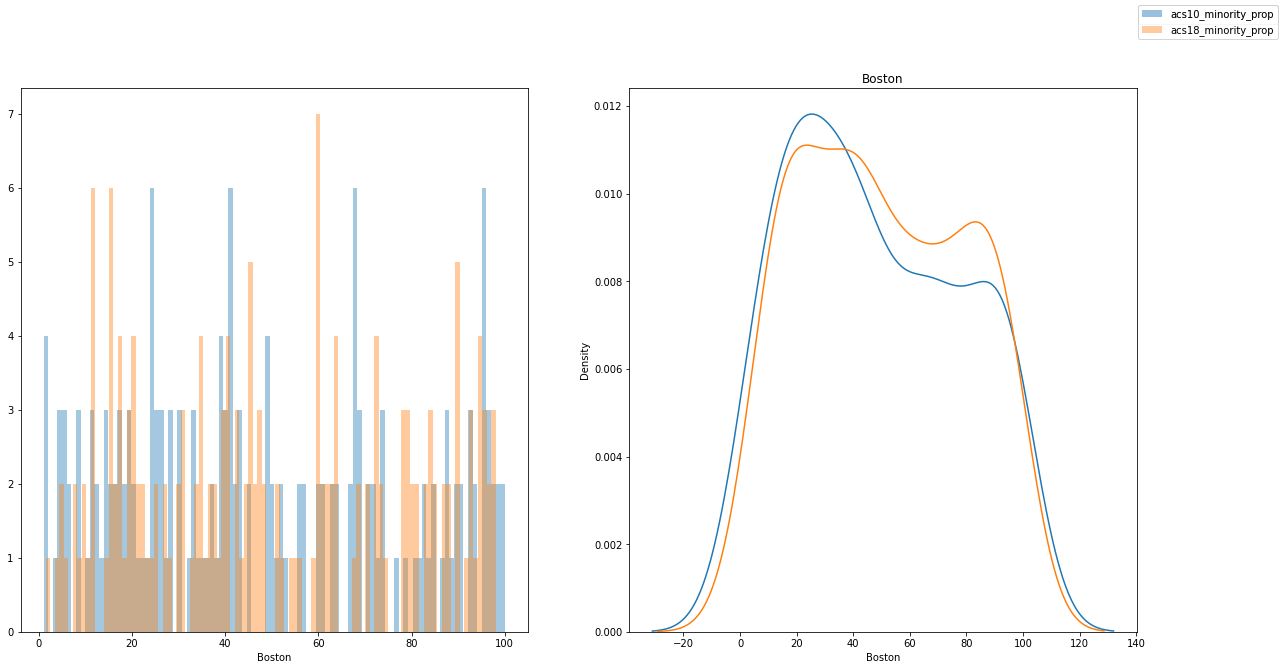

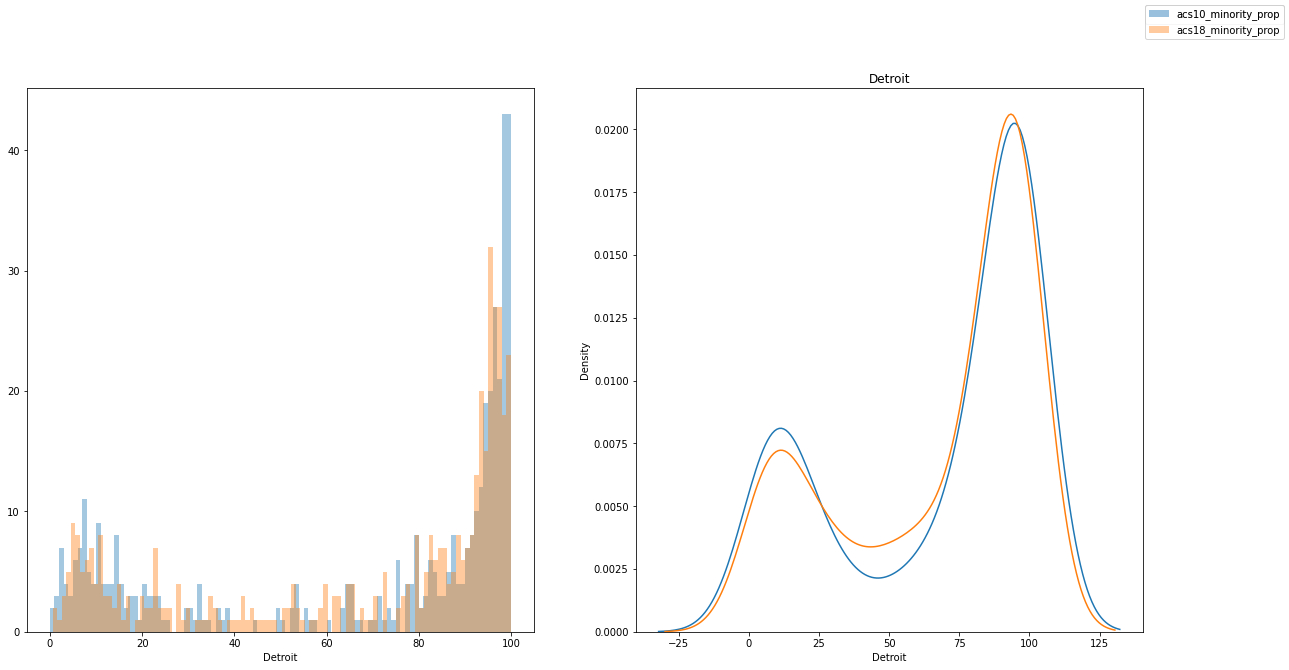

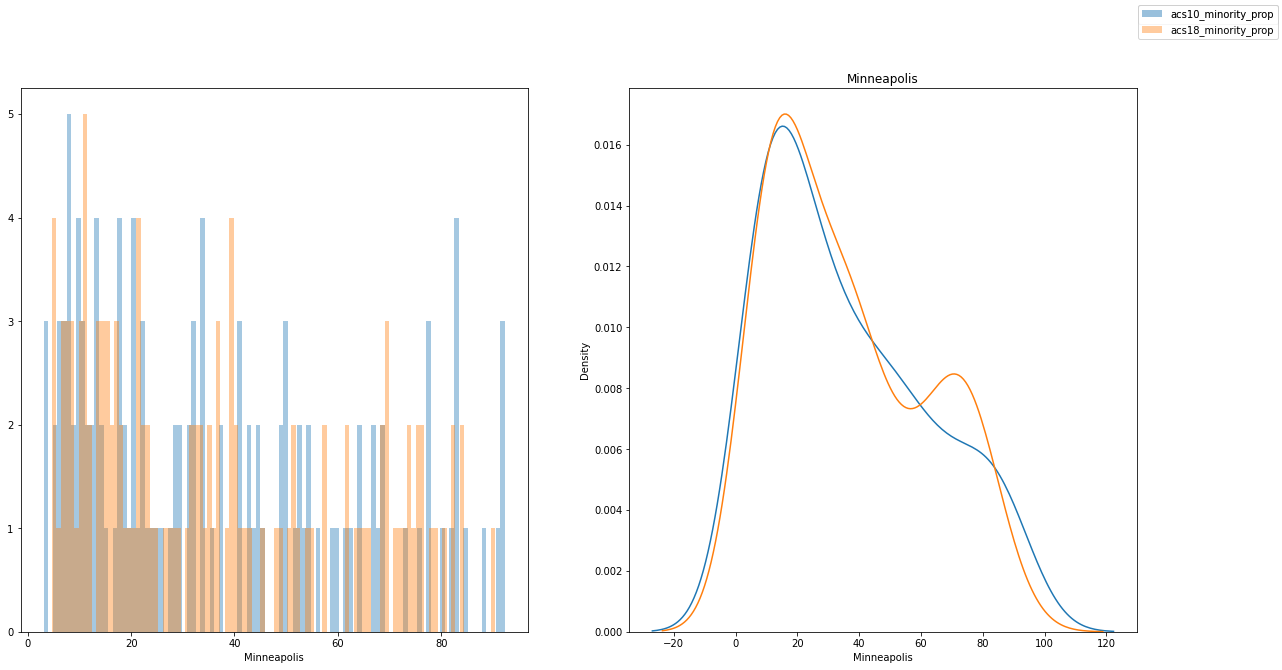

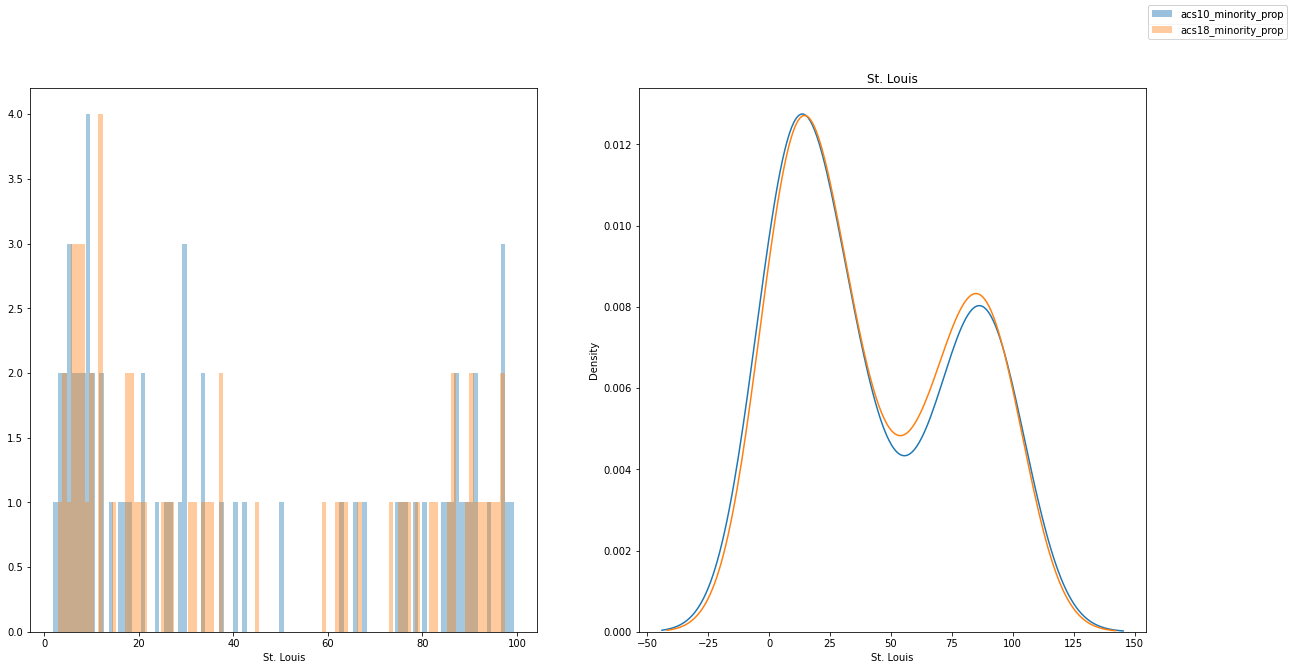

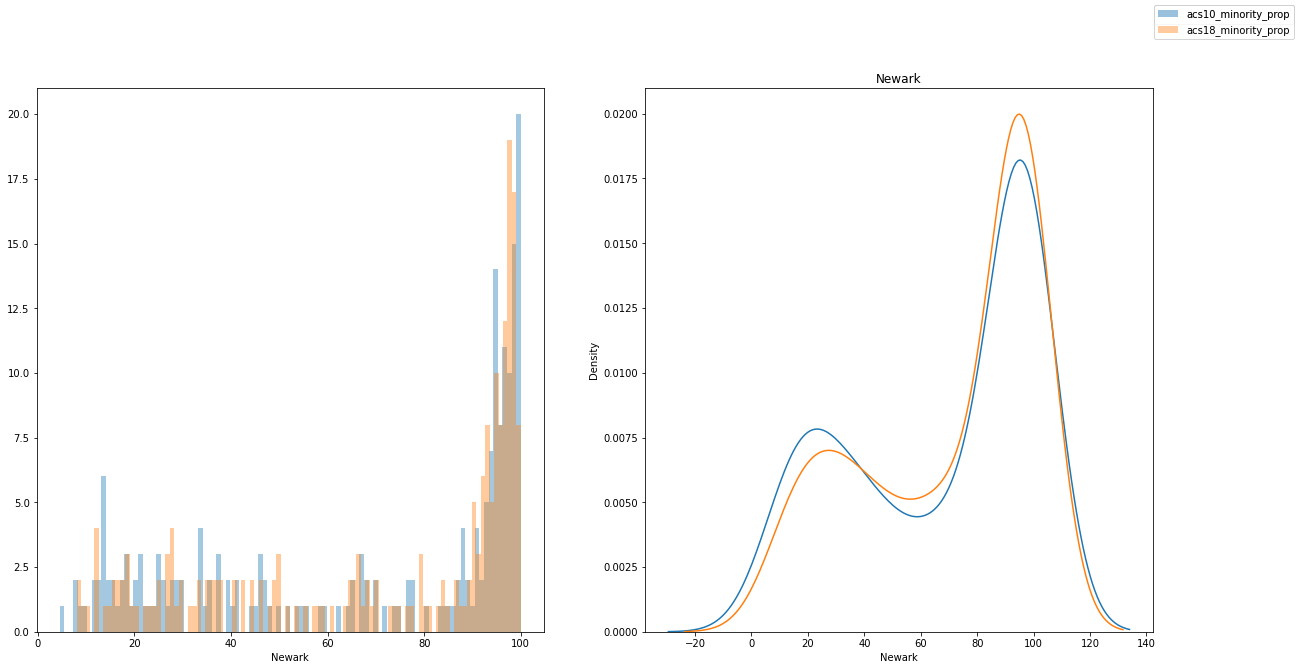

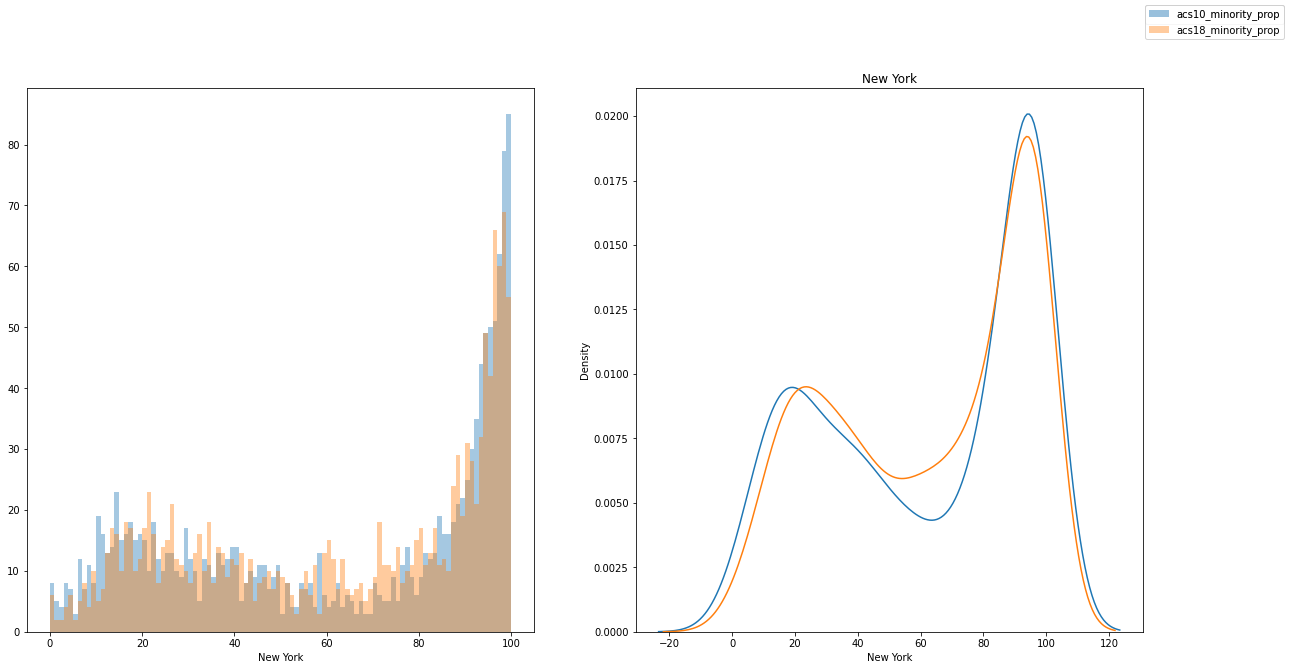

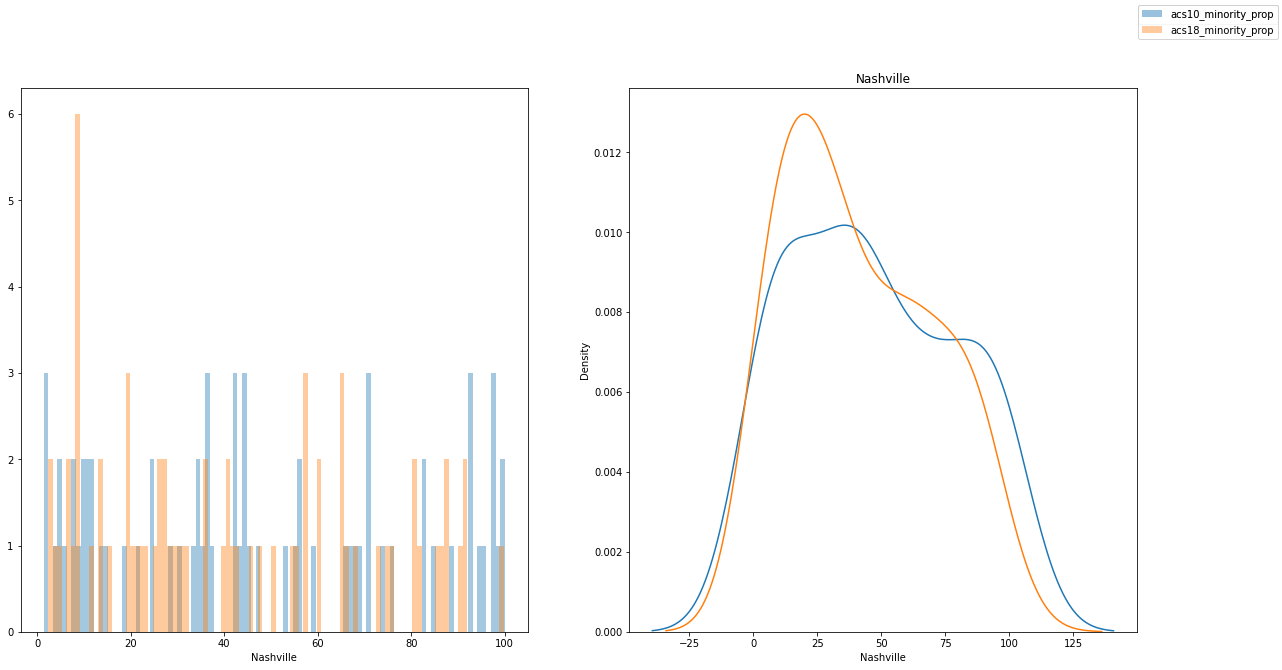

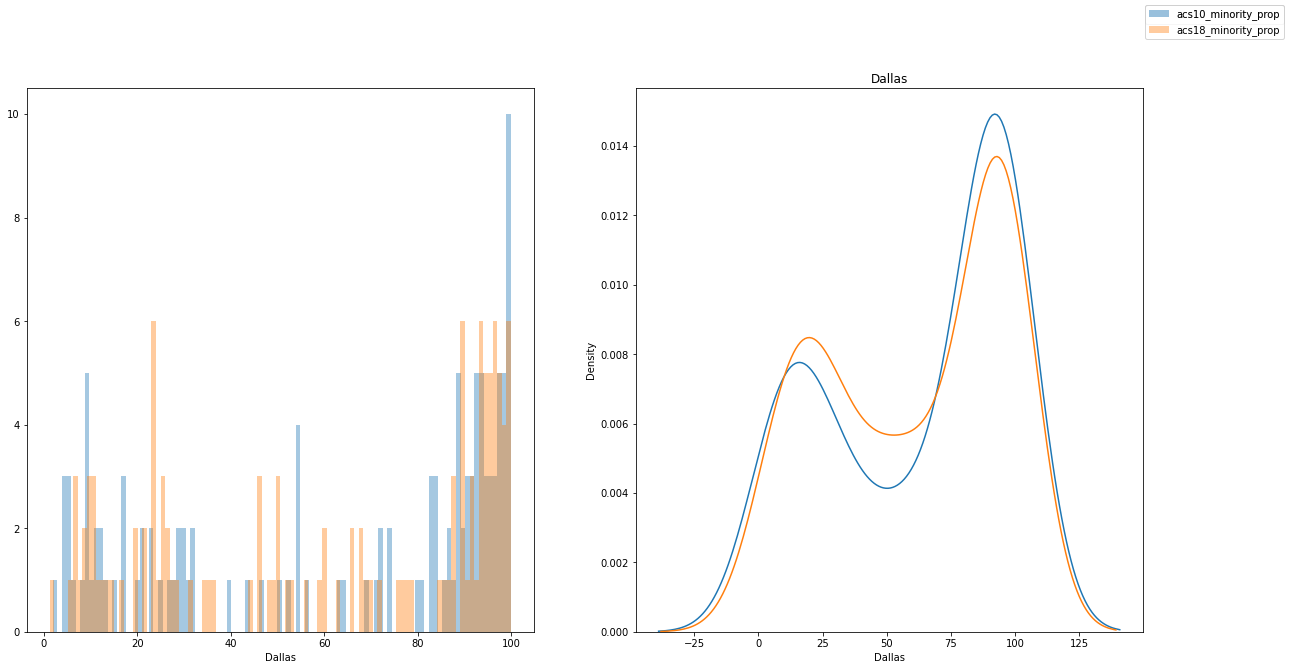

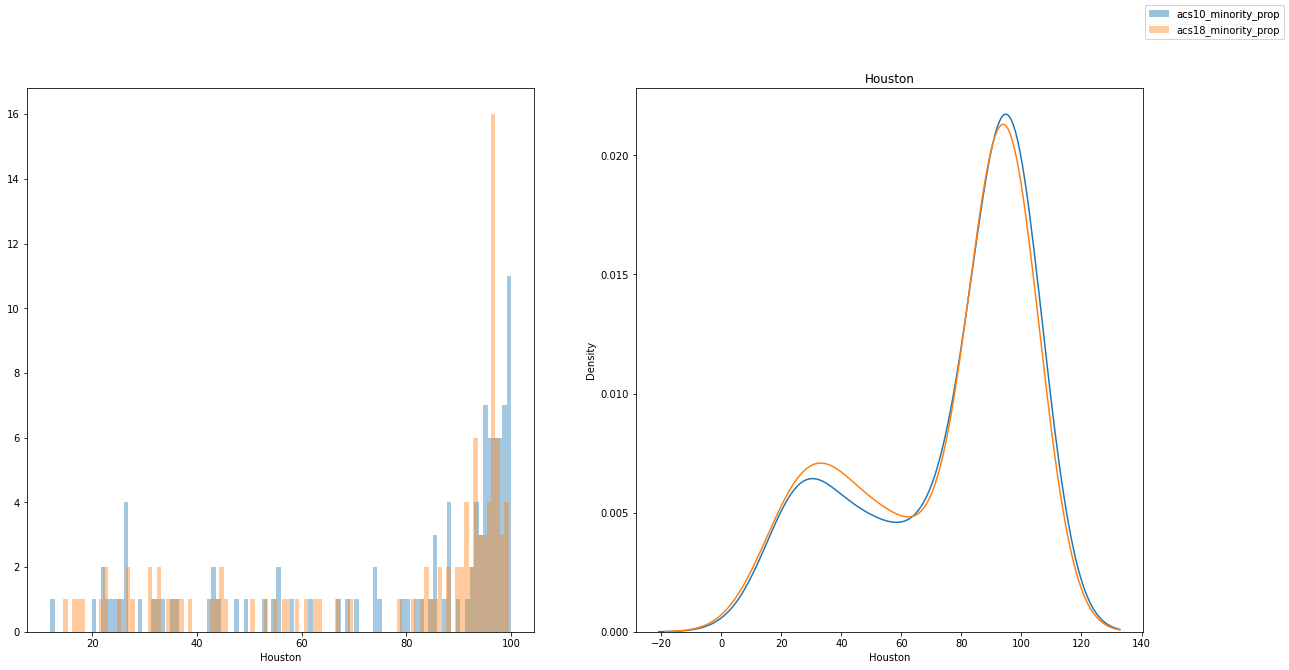

In [ ]:
#Visualising changes in 2010 and 2018 minority populations for each city
for i in minority_hist_df['city_name'].unique():
    fig, axes = plt.subplots(1,2, figsize = (20,10))
    for a in ['acs10_minority_prop', 'acs18_minority_prop']:
        sns.distplot(minority_hist_df[minority_hist_df['city_name']==i][a], bins=100, ax=axes[0], kde=False,label = a,axlabel=i)
        plt.xlabel(i)
        plt.title(i)
        fig.legend()
        sns.kdeplot(minority_hist_df[minority_hist_df['city_name']==i][a],ax=axes[1])
    #plt.show()

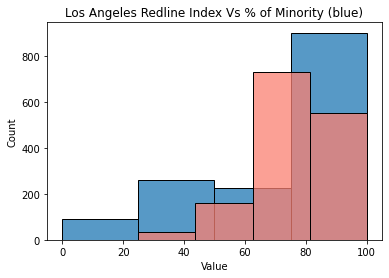

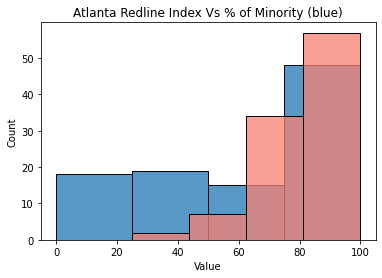

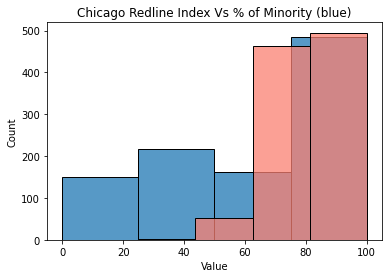

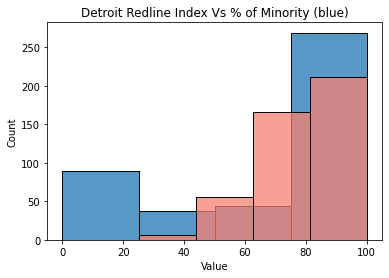

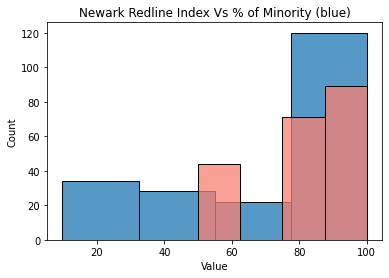

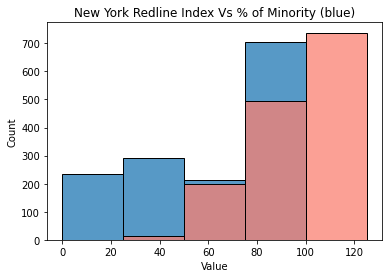

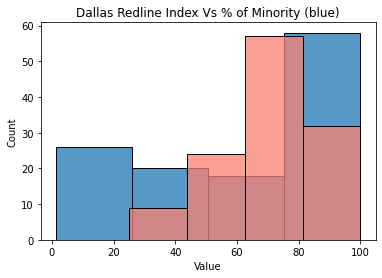

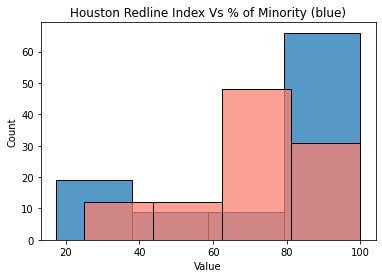

In [ ]:
# Separating out cities having Right Skewed Distributions and visualising number of tracts within each range of redline and rental index

## Right Skewed Only
city_list = ['Los Angeles', 'Atlanta','Chicago','Detroit','Newark','New York','Dallas','Houston']
minority_hist_df['redlining_index'] = spatial_corr_data[['redlining_index']]*25
minority_hist_df['rental_assistance_index'] = spatial_corr_data[['rental_assistance_index']]*100
for i in city_list:
    fig, ax = plt.subplots()
    sns.histplot(minority_hist_df[minority_hist_df['city_name']==i]['percentage_minority'], bins = 4, ax = ax,legend=True)
    sns.histplot(minority_hist_df[minority_hist_df['city_name']==i]['redlining_index'], bins = 4, color='salmon',ax = ax,legend=True)
    #sns.histplot(minority_hist_df[minority_hist_df['city_name']==i]['housing_inequality_index'], bins = 5,ax = ax)
    ax.set_xlabel('Value')
    ax.set_title('{} Redline Index Vs % of Minority (blue)'.format(i))

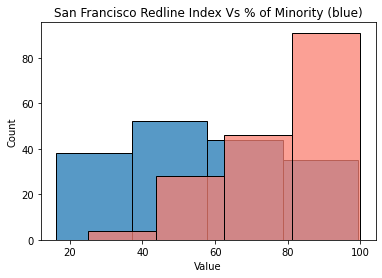

In [ ]:
# Cities having normally distributed minority populations
city_list = ['San Francisco']
minority_hist_df['redline_index'] = spatial_corr_data[['ordinal_value']]*25
minority_hist_df['housing_inequality_index'] = spatial_corr_data[['total_index_quantile']]*100
for i in city_list:
    fig, ax = plt.subplots()
    sns.histplot(minority_hist_df[minority_hist_df['city_name']==i]['perc_person_of_color'], bins = 4, ax = ax,legend=True)
    sns.histplot(minority_hist_df[minority_hist_df['city_name']==i]['redline_index'], bins = 4, color='salmon',ax = ax,legend=True)
    #sns.histplot(minority_hist_df[minority_hist_df['city_name']==i]['housing_inequality_index'], bins = 5,ax = ax)
    ax.set_xlabel('Value')
    ax.set_title('{} Redline Index Vs % of Minority (blue)'.format(i))

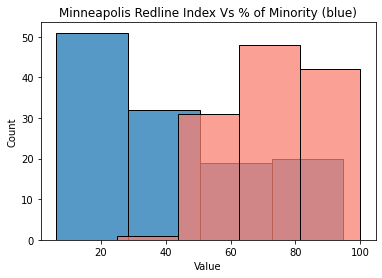

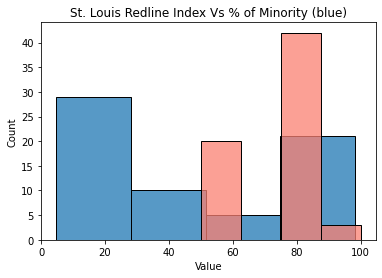

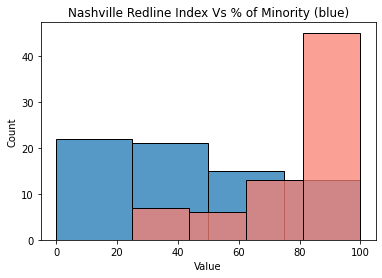

In [ ]:
#Cities with Left Skew Distributions
city_list = ['Minneapolis','St. Louis','Nashville']
minority_hist_df['redlining_index'] = spatial_corr_data[['redlining_index']]*25
minority_hist_df['rental_assistance_index'] = spatial_corr_data[['rental_assistance_index']]*100
for i in city_list:
    fig, ax = plt.subplots()
    sns.histplot(minority_hist_df[minority_hist_df['city_name']==i]['percentage_minority'], bins = 4, ax = ax,legend=True)
    sns.histplot(minority_hist_df[minority_hist_df['city_name']==i]['redlining_index'], bins = 4, color='salmon',ax = ax,legend=True)
    #sns.histplot(minority_hist_df[minority_hist_df['city_name']==i]['housing_inequality_index'], bins = 5,ax = ax)
    ax.set_xlabel('Value')
    ax.set_title('{} Redline Index Vs % of Minority (blue)'.format(i))

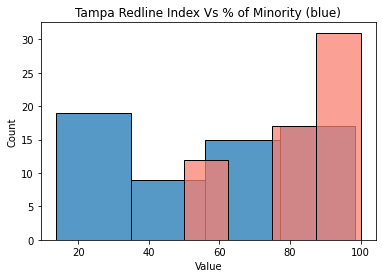

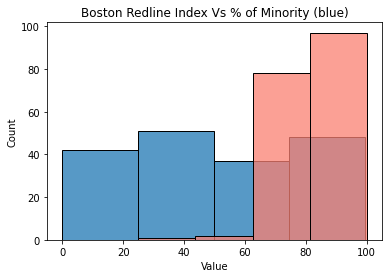

In [ ]:
# Cities with Bimodal/Uniform Distributions
city_list = ['Tampa','Boston']
minority_hist_df['redlining_index'] = spatial_corr_data[['redlining_index']]*25
minority_hist_df['rental_assistance_index'] = spatial_corr_data[['rental_assistance_index']]*100
for i in city_list:
    fig, ax = plt.subplots()
    sns.histplot(minority_hist_df[minority_hist_df['city_name']==i]['percentage_minority'], bins = 4, ax = ax,legend=True)
    sns.histplot(minority_hist_df[minority_hist_df['city_name']==i]['redlining_index'], bins = 4, color='salmon',ax = ax,legend=True)
    #sns.histplot(minority_hist_df[minority_hist_df['city_name']==i]['housing_inequality_index'], bins = 5,ax = ax)
    ax.set_xlabel('Value')
    ax.set_title('{} Redline Index Vs % of Minority (blue)'.format(i))

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c9a4f701-31a5-4164-b3f3-c09cddf1309e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>